<ipython-input-26-02ddc071bac1>:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


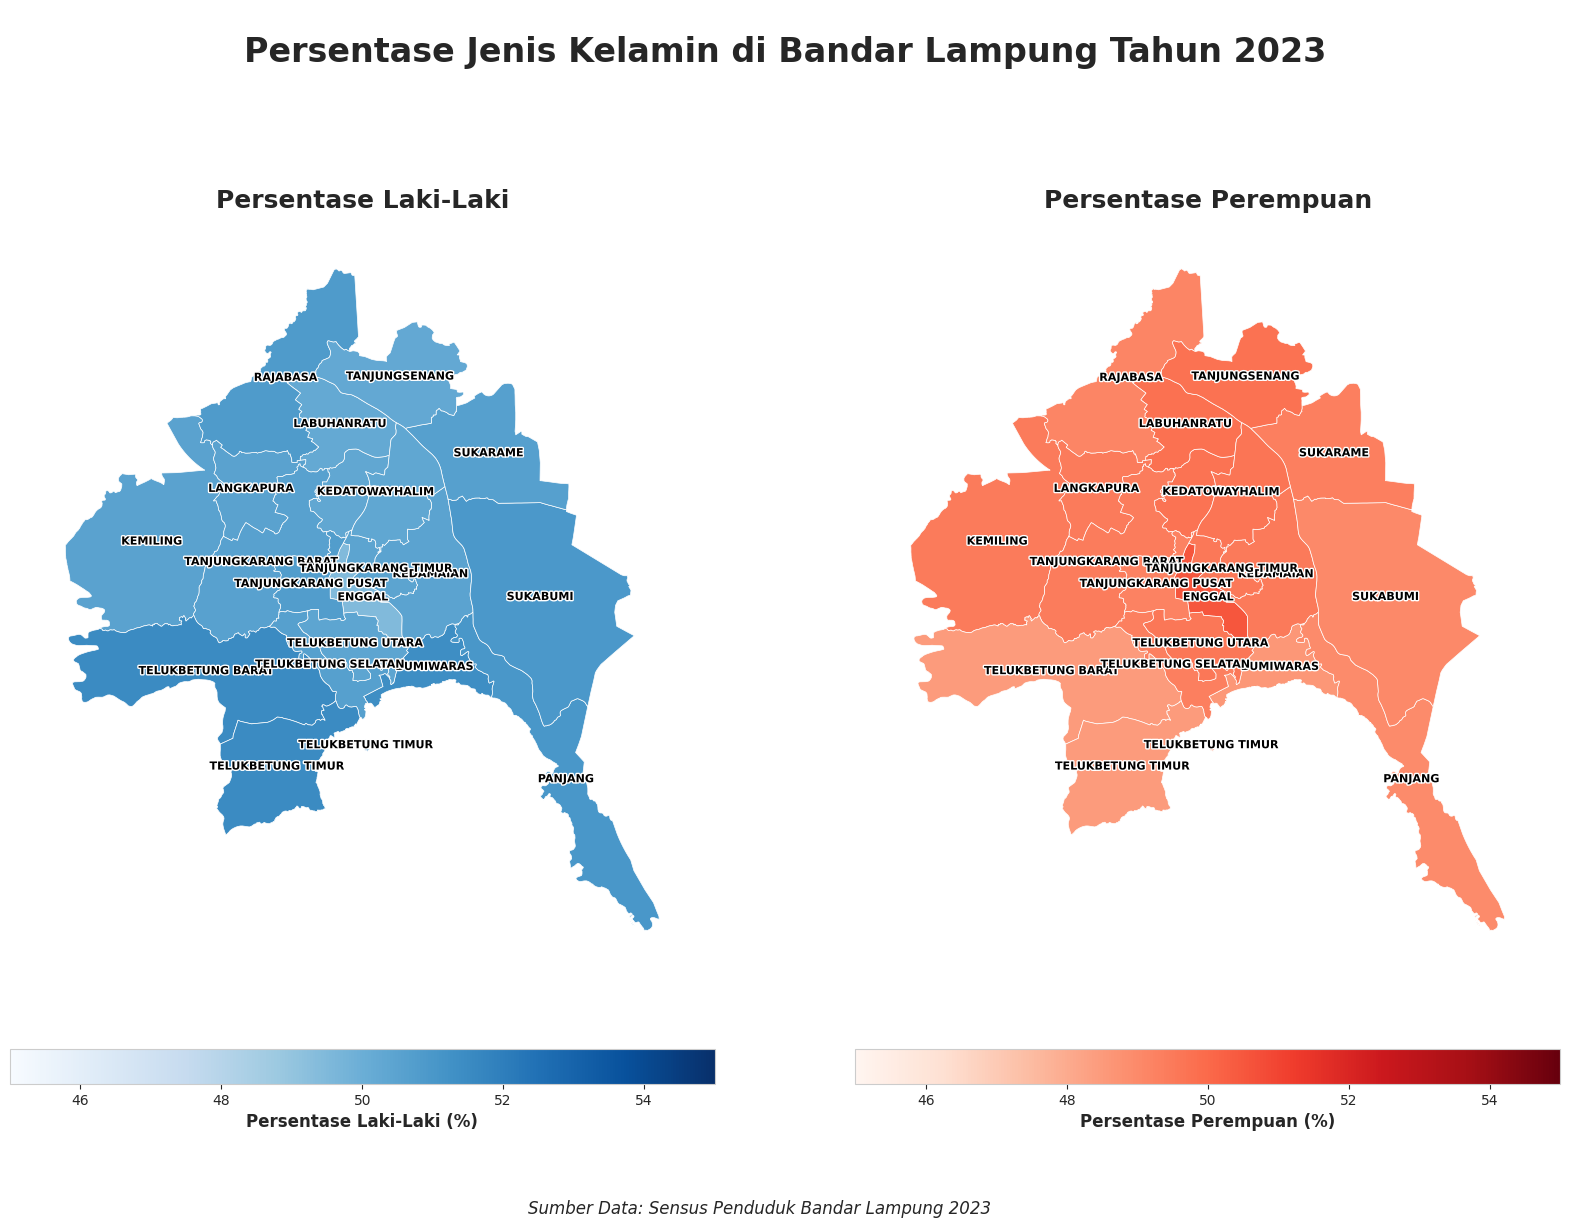

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib.colors as colors
import seaborn as sns
from matplotlib import patheffects

# Mengatur gaya seaborn untuk plot yang lebih estetik
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Helvetica', 'Arial', 'sans-serif']

# Mengatur path untuk file CSV dan shapefile
csv_path = 'sensus jenis kelamin_bandar lampung.csv'
shape_path = '/content/ADMINISTRASIKECAMATAN_AR_50K.shx'

# Membaca dan memproses data
data_jk = pd.read_csv(csv_path)
shape = gpd.read_file(shape_path)

data_jk.columns = ['KECAMATAN', 'LAKI-LAKI', 'PEREMPUAN']
data_jk['Persentase Laki-Laki'] = data_jk['LAKI-LAKI'] / (data_jk['LAKI-LAKI'] + data_jk['PEREMPUAN']) * 100
data_jk['Persentase Perempuan'] = data_jk['PEREMPUAN'] / (data_jk['LAKI-LAKI'] + data_jk['PEREMPUAN']) * 100

data_jk['KECAMATAN'] = data_jk['KECAMATAN'].str.strip().str.upper()
shape['NAMOBJ'] = shape['NAMOBJ'].str.strip().str.upper()

shape_merged = pd.merge(left=shape, right=data_jk, left_on='NAMOBJ', right_on='KECAMATAN', how='outer')

# Membuat plot dengan dua subplot dan ruang untuk judul utama
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[1, 10], hspace=0.3)

# Menambahkan judul utama
ax_title = fig.add_subplot(gs[0, :])
ax_title.axis('off')
ax_title.text(0.5, 0.5, 'Persentase Jenis Kelamin di Bandar Lampung Tahun 2023',
              fontsize=24, fontweight='bold', ha='center', va='center')

# Membuat subplot untuk peta
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])

# Fungsi untuk membuat peta choropleth yang lebih estetik
def create_aesthetic_choropleth(ax, data, column, title, cmap, vmin, vmax):
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    data.plot(ax=ax, column=column, cmap=cmap, norm=norm, edgecolor='white', linewidth=0.5)

    # Menambahkan colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1)
    cbar.set_label(f'Persentase {column.split()[-1]} (%)', fontsize=12, fontweight='bold')
    cbar.ax.tick_params(labelsize=10)

    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.axis('off')

    # Menambahkan label kecamatan dengan ukuran berdasarkan area
    for idx, row in data.iterrows():
        if row.geometry is not None and row.geometry.is_valid:
            centroid = row.geometry.centroid
            area = row.geometry.area
            fontsize = min(max(8, area * 0.0001), 12)  # Menyesuaikan ukuran font berdasarkan area
            ax.annotate(text=row['NAMOBJ'], xy=(centroid.x, centroid.y), ha='center', va='center',
                        fontsize=fontsize, fontweight='bold', color='black', path_effects=[
                            patheffects.withStroke(linewidth=2, foreground="white")])

# Menentukan range nilai untuk normalisasi warna
vmin, vmax = 45, 55

# Membuat peta choropleth untuk Laki-Laki
create_aesthetic_choropleth(ax1, shape_merged, 'Persentase Laki-Laki', 'Persentase Laki-Laki', plt.cm.Blues, vmin, vmax)

# Membuat peta choropleth untuk Perempuan
create_aesthetic_choropleth(ax2, shape_merged, 'Persentase Perempuan', 'Persentase Perempuan', plt.cm.Reds, vmin, vmax)

# Menambahkan penjelasan
fig.text(0.5, 0.02, 'Sumber Data: Sensus Penduduk Bandar Lampung 2023', ha='center', fontsize=12, fontstyle='italic')

plt.tight_layout()
plt.show()